# Recognition of Handwritten Numerals
## Dataset: zipcode data 
* Training data set and Testing data set
* Each line of data consists the digit ID (0-9) followed by 16*16 matrix of pixels
* Data were available by the neural network group at AT&T research labs

## Goal: Identify Numerals from the Pixel Matrices
* Identification can be considered as classification problem
* Classify the input into categories 0-9


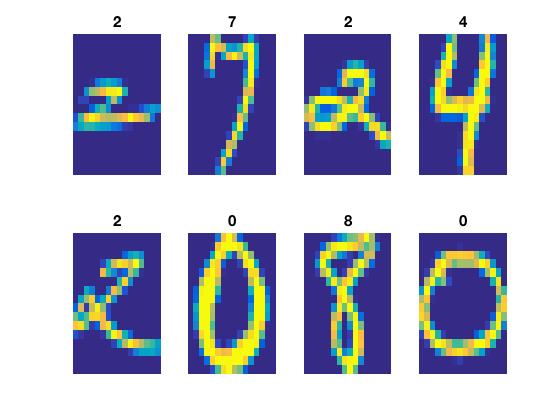

In [1]:
% Take a look at the data. This code displays a randomly selected subset of rows from zip.train

zip = feval('load','zip.train'); 
ind = randsample(size(zip,1),8); 
figure;
for n = 1:length(ind);
    for i = 1:16;
        for j = 1:16;
            im(i,j) = zip(ind(n),1+(i-1)*16+j); 
        end
    end
    subplot(2,4,n); 
    imagesc(im);title(num2str(zip(ind(n),1)));axis off;
end

## Method: Multi-Class Logistic Regression
* Basic assumption of Logistic Regression is
$$ logit(\pi(x_i))=log\frac{p(x_i;\beta)}{1-p(x_i;\beta)} $$
  We want to maximize the joint log likelihood, i.e.,
$$ l(\beta|x_1,...,x_n)=\sum_{i=1}^{n}[y_i(\beta_0+x_i\beta_1)-log(1+e^{\beta_0+x_i\beta_1})] $$
* Logistic regression for multiple classes, like K, can be considered as K binary logistic regressions. For category, a linear logistic regression function can be learned from training data:
$$ F_{i,k}=F_k(x_i)=x_i\beta_k \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;(1)$$


* We fit K binary classficiation problems (one vs. rest) individually and at the end we jointly update the probabilities

$$ p_{i,k}=\frac{e^{F_{i,k}}}{\sum_{s=0}^{K-1}e^{F_{i,k}}}=\frac{e^{F_{i,k}}}{\sum_{s=0}^{K-1}e^{x_i\beta_k}}\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;(2) $$            
    The joint log likelihood can be written as
$$ l(\beta)=\sum_{i=1}^{n}l_i=\sum_{i=1}^{n}\{\sum_{k=0}^{K-1}r_{i,k}logp_{i,k}\} $$

$$ 
r_{i,k}= \begin {cases}
1\;\;\;\; if y_i=k \\0\;\;\;\; otherwise
\end {cases} 
$$

  After derivation and manipulation, the total log likelihood can be now written as
$$ l(\beta)=\sum_{i=1}^{n}\{\sum_{k=0}^{K-1}r_{i,k}logp_{i,k}\}-\frac{\lambda}{2}\sum_{k=0}^{K-1}\sum_{j=0}^{d}\beta_{k,j}^2 $$

$$ 
r_{i,k}= \begin {cases}
1\;\;\;\; if y_i=k \\0\;\;\;\; otherwise
\end {cases} 
$$
* $\beta$ can be learned based on Newton's updating formula

$$ \beta_k^t=\beta_k^{(t-1)}+\nu[X^TW_k^{(t-1)}X+\lambda{I}]^{-1}[X^T(r_k-p_k^{t-1})-\lambda\beta_k^{t-1})]\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;(3)$$
    
  $\nu$ is a heuristic "shrinkage" factor, often $\nu=0.1$ works well

  $\beta_k$ (k=0 to K-1) is a weight vector of length p+1

  $p_k$ (k=0 to K-1) is a probability vector of length n

  $W_k$ is an diagonal matrix $p_{i,k}*(1-p_{i,k})$ (i=1 to n)

## A Function to Fit and Predict Data Using Multi-Class Logisitic Regression

In [2]:
%%file FitMultiLogit.m

% This function taks training dataset and testing dataset as input. X and Xt are pixel matrices. Y and Yt are digit IDs.
% Number of iterations, v, and lambda can be defined by users.
% It outputs misclassification errors (in percent) for both training and testing datasets and log-likelihood.

function [err, loglik, err_t] = FitMultiLogit(X,Y,Xt,Yt,numIter,v,lam)

% Initialize number of categories, dimensions, beta matrix, estimated category matrix (Ye: # of obs. * 10).

K = max(Y); d = size(X,2);  be = zeros(d,K);
Ye = zeros(length(Y),K);     
Ye = (Y == (1:10));

% Iterative learning and updating beta from training dataset
% Applying learned beta in predicting categories of testing dataset
% Misclassification errors are calculated for both training and testing dataset
% Log likelihood is calculated for training dataset

for m=1:numIter    
    iteration = m    
    
    % Calculations based on formula (1) and (2)
    F = X*be; 
    S= sum(exp(F),2);  
    for k = 1:K
        P(:,k) = exp(F(:,k))./S;
    end   
   
    % Calculations based on formula (3)  
    for k = 1:K                         
        Z = (P(:,k).*(1-P(:,k))*ones(1,d).*X)'*X;
        be(:,k) = be(:,k) + (Z+lam*eye(d))\(X'*(Ye(:,k)-P(:,k))-be(:,k)*lam)*v;          
    end;    
    
    % Calculating error rate and log likelihood for training
    [~, Y_hat] = max(P,[],2);    
    err(m) = mean(Y_hat ~= Y);
    loglik(m) = sum(sum(log(P).*Ye,2));    
    
    % Calculating error rate for testing
    Ft = Xt*be;    
    [~, Yt_hat] = max(Ft,[],2);   
    err_t(m) = mean(Yt_hat ~= Yt);
end

Created file '/Users/Meng/Python/FitMultiLogit.m'.


## A Function to Test the Regression Model Given Datasets, $\nu$, $\lambda$, and Number of Iterations

In [3]:
%%file TestMultiLogit.m

function TestMultiLogit(v,Lam,numIter)

% Read Data
% Y and Yt are digit IDs (now from 1 to 10). They are 7291*1 vectors.
% X and Xt are 7291*257 pixel matrices (the first column is all 1).

data = feval('load','zip.train');  
X = data(:,2:end); Y = data(:,1)+1;  X = [X(:,1)*0+1 X];

data = feval('load','zip.test');
Xt = data(:,2:end); Yt = data(:,1)+1;  Xt = [Xt(:,1)*0+1 Xt];

% Record time to evaluate the efficiency of the algorithm
tic;

m = 1:numIter;

for lam = Lam
    [err, loglik, err_t]  = FitMultiLogit(X,Y,Xt,Yt,numIter,v,lam);

% Plot the mis-classification error for training  data
    figure(1);
    plot(m,err*100,'linewidth',2); hold on; grid on; set(gca,'FontSize',20);
    xlabel('Iteration'); ylabel('Mis-Classification Error (%)');
    text(m(end),err(end)*100,['\lambda = ' num2str(lam)]);  
    axis([1 numIter 0 16]);            
    title(['Train Mis-Classfication Error: \nu = ' num2str(v)]);

% Plot the log likelihood for training  data
    figure(2);
    plot(m,loglik,'linewidth',2); hold on; grid on; set(gca,'FontSize',20);
    xlabel('Iteration'); ylabel('Log likelihood');    
    text(m(end),loglik(end),['\lambda = ' num2str(lam)]);
    axis([1 numIter -15000 1000]);
    title(['Train Log Likelihood: \nu = ' num2str(v)]);    

% Plot the mis-classification error for testing  data
    figure(3);
    plot(m,err_t*100,'linewidth',2); hold on; grid on; set(gca,'FontSize',20);
    xlabel('Iteration'); ylabel('Mis-Classification Error (%)');
    text(m(end),err_t(end)*100,['\lambda = ' num2str(lam)]);  
    axis([1 numIter 5 30]);    
    title(['Test Mis-Classfication Error: \nu = ' num2str(v)]);    
end

toc;

Created file '/Users/Meng/Python/TestMultiLogit.m'.



iteration =

     1


iteration =

     2


iteration =

     3


iteration =

     4


iteration =

     5


iteration =

     6


iteration =

     7


iteration =

     8


iteration =

     9


iteration =

    10


iteration =

    11


iteration =

    12


iteration =

    13


iteration =

    14


iteration =

    15


iteration =

    16


iteration =

    17


iteration =

    18


iteration =

    19


iteration =

    20


iteration =

    21


iteration =

    22


iteration =

    23


iteration =

    24


iteration =

    25


iteration =

    26


iteration =

    27


iteration =

    28


iteration =

    29


iteration =

    30


iteration =

    31


iteration =

    32


iteration =

    33


iteration =

    34


iteration =

    35


iteration =

    36


iteration =

    37


iteration =

    38


iteration =

    39


iteration =

    40


iteration =

    41


iteration =

    42


iteration =

    43


iteration =

    44


iteration =

    45


iteration

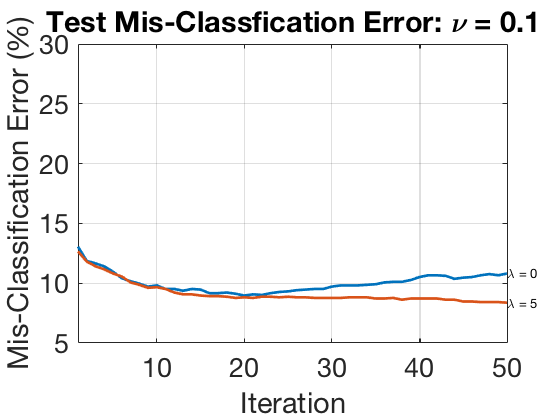

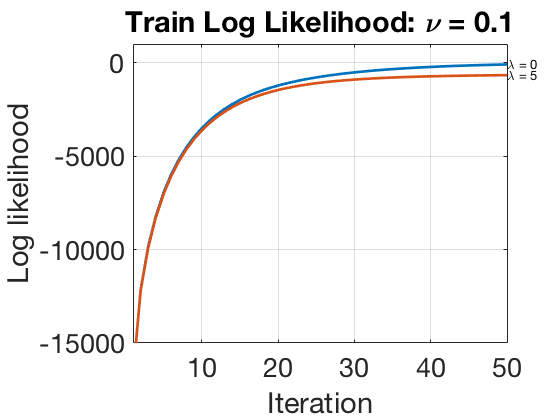

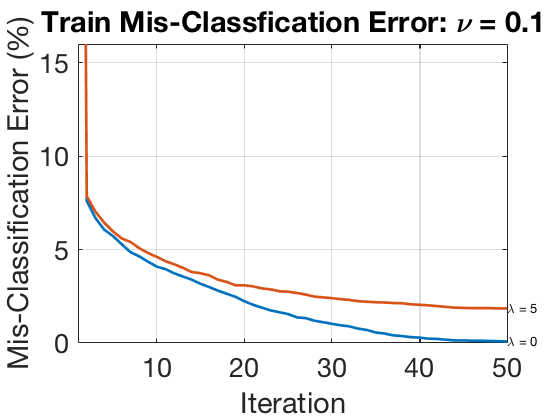

In [5]:
TestMultiLogit(0.1,[0,5],50)